# Note
This notebook:
- transform .tiff images into numpy vectors
- transforms the labels from GEOJson format to binary masks/images (numpy vectors as well)
- save all these vectors into .npy files for later use

In [2]:
import solaris as sol
from solaris.data import data_dir
import os
import skimage
import cv2
import numpy as np

import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

/home/balfra/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/balfra/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/balfra/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/balfra/anaconda3/envs/solaris/lib/pyt

In [3]:
image = cv2.imread("aaa.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = skimage.io.imread(os.path.join(data_dir, 'sample_geotiff.tif'))
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image, cmap='gray')
image = image[:1023,:1023,:]

error: OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


ma uint8
ma1 float64


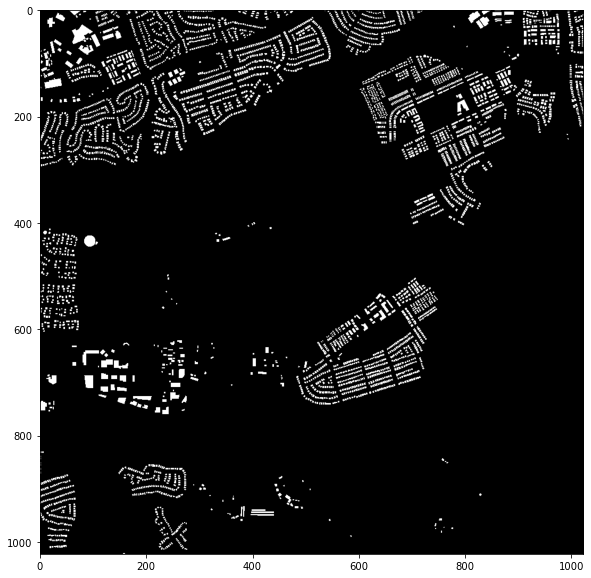

In [6]:
fp_mask = sol.vector.mask.footprint_mask(df="ultimo.geojson", shape=(1023,1023))#,
                                      #reference_im="/home/balfra/EPFL/EO/aaa.tif")
f, ax = plt.subplots(figsize=(10, 10))
print("ma", fp_mask.dtype)
fp_mask = np.divide(fp_mask, 255.)
print("ma1", fp_mask.dtype)

plt.imshow(fp_mask, cmap='gray')

## Load images from dirs

In [8]:
rootdir = "/home/balfra/EPFL/EO/SN7_buildings_train/train"
external_dirs = os.listdir(rootdir)
external_dirs.sort()
train_test_ratio = 0.67 # 2/3
train_iters = int(len(external_dirs) * train_test_ratio)

In [16]:
img_shape = 1023

train_imgs_flag = False
train_labels_flag = False
test_imgs_flag = False
test_labels_flag = False

train_imgs = np.array([])
train_labels = np.array([])
test_imgs = np.array([])
test_labels = np.array([])

for i, external_dir in enumerate(external_dirs):
    if i in range(10,20):
        print("Iteration", i)
        external_dirs_path = os.path.join(rootdir, external_dir)
        if i < train_iters: # train 
            internal_dirs = os.listdir(external_dirs_path)
            for internal_dir in internal_dirs:
                internal_dirs_path = os.path.join(external_dirs_path, internal_dir)
                if internal_dir == "images":
                    images = os.listdir(internal_dirs_path)
                    images.sort()
                    for image in images:
                        # read image
                        img = cv2.imread(os.path.join(internal_dirs_path, image))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = img[:img_shape,:img_shape,:] # crop to (img_shape,img_shape,3) shape
                        # insert in numpy array
                        if train_imgs_flag == False:
                            train_imgs = np.expand_dims(img, axis=0)
                            train_imgs_flag = True
                        else:
                            img = np.expand_dims(img, axis=0)
                            train_imgs = np.concatenate([train_imgs, img], axis=0)

                elif internal_dir == "labels_match_pix":
                    labels_gjson = os.listdir(internal_dirs_path)
                    labels_gjson.sort()
                    for label_gjson in labels_gjson:
                        # get mask from geojson
                        mask = sol.vector.mask.footprint_mask(df=os.path.join(internal_dirs_path, label_gjson), shape=(img_shape, img_shape))
                        # normalize it in [0,1]
                        #mask = np.divide(mask, 255.)
                        # insert in numpy array
                        if train_labels_flag == False:
                            train_labels = np.expand_dims(mask, axis=0)
                            train_labels_flag = True
                        else:
                            mask = np.expand_dims(mask, axis=0)
                            train_labels = np.concatenate([train_labels, mask], axis=0)

        else: # test
            internal_dirs = os.listdir(external_dirs_path)
            for internal_dir in internal_dirs:
                internal_dirs_path = os.path.join(external_dirs_path, internal_dir)
                if internal_dir == "images":
                    images = os.listdir(internal_dirs_path)
                    images.sort()
                    for image in images:
                        # read image
                        img = cv2.imread(os.path.join(internal_dirs_path, image))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = img[:img_shape,:img_shape,:] # crop to (img_shape,img_shape,3) shape
                        # insert in numpy array
                        if test_imgs_flag == False:
                            test_imgs = np.expand_dims(img, axis=0)
                            test_imgs_flag = True
                        else:
                            img = np.expand_dims(img, axis=0)
                            test_imgs = np.concatenate([test_imgs, img], axis=0)

                elif internal_dir == "labels_match_pix":
                    labels_gjson = os.listdir(internal_dirs_path)
                    labels_gjson.sort()
                    for label_gjson in labels_gjson:
                        # get mask from geojson
                        mask = sol.vector.mask.footprint_mask(df=os.path.join(internal_dirs_path, label_gjson), shape=(img_shape, img_shape))
                        # normalize it in [0,1]
                        #mask = np.divide(mask, 255.)
                        # insert in numpy array
                        if test_labels_flag == False:
                            test_labels = np.expand_dims(mask, axis=0)
                            test_labels_flag = True
                        else:
                            mask = np.expand_dims(mask, axis=0)
                            test_labels = np.concatenate([test_labels, mask], axis=0)


Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


In [17]:
index_name = str(2)
np.save("train_imgs_" + index_name + ".npy", train_imgs)
np.save("train_labels_" + index_name + ".npy", train_labels)
#np.save("test_imgs_" + index_name + ".npy", test_imgs)
#np.save("test_labels_" + index_name + ".npy", test_labels)

```train_imgs = np.load("train_imgs_" + index_name + ".npy")
train_labels = np.load("train_labels_" + index_name + ".npy")
test_imgs = np.load("test_imgs_" + index_name + ".npy")
test_labels = np.load("test_labels_" + index_name + ".npy")```